<a href="https://colab.research.google.com/github/NajimovOtabek/Assignment_SW/blob/main/Transformer_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
!unzip MachineLearningCSV.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
To: /content/MachineLearningCSV.zip
100% 235M/235M [00:05<00:00, 43.5MB/s]
Archive:  MachineLearningCSV.zip
   creating: MachineLearningCVE/
  inflating: MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  i

In [ ]:
!wget https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py

--2023-09-14 03:26:31--  https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3790 (3.7K) [text/plain]
Saving to: ‘preprocessing.py’

preprocessing.py    100%[===================>]   3.70K  --.-KB/s    in 0s      

2023-09-14 03:26:31 (70.1 MB/s) - ‘preprocessing.py’ saved [3790/3790]



In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, classification_report
from preprocessing import read_data, load_data, normalize
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os

In [ ]:
dataroot = 'MachineLearningCVE/'
from preprocessing import read_data
data = read_data(dataroot,'*.pcap_ISCX.csv')

[########################################] | 100% Completed | 31.22 s


In [ ]:
# Load and normalize the data
X, y = load_data(dataroot)
X = normalize(X)

[########################################] | 100% Completed | 30.31 s
there are 2830743 flow records with 79 feature dimension
stripped column names
dropped bad columns
There are 0 nan entries
converted to numeric


In [ ]:
from collections import Counter
import numpy as np

def filter_and_rename_classes(X, y, threshold=1000):
    # Count occurrences of each class in y
    class_counts = Counter(y)

    # Print "before" state
    print("Before filtering:")
    print(f"X length: {len(X)}")
    print(f"y length: {len(y)}")
    print(f"Class counts: {class_counts}")

    # Find the valid classes based on the threshold
    valid_classes = [cls for cls, count in class_counts.items() if count >= threshold]

    # Create a dictionary to map old class names to new ones
    rename_map = {old: new for new, old in enumerate(sorted(valid_classes))}

    # Filter and rename classes
    X_filtered = []
    y_filtered = []
    for x, cls in zip(X, y):
        if cls in valid_classes:
            X_filtered.append(x)
            y_filtered.append(rename_map[cls])

    # Convert to numpy arrays
    X_filtered = np.array(X_filtered)
    y_filtered = np.array(y_filtered)

    # Print "after" state
    print("After filtering and renaming:")
    print(f"X_filtered length: {len(X_filtered)}")
    print(f"y_filtered length: {len(y_filtered)}")
    print(f"Filtered and renamed class counts: {Counter(y_filtered)}")

    return X_filtered, y_filtered

# Filter and rename classes
X, y = filter_and_rename_classes(X, y)


Before filtering:
X length: 2830743
y length: 2830743
Class counts: Counter({0: 2273097, 4: 231073, 10: 158930, 2: 128027, 3: 10293, 7: 7938, 11: 5897, 6: 5796, 5: 5499, 1: 1966, 12: 1507, 14: 652, 9: 36, 13: 21, 8: 11})
After filtering and renaming:
X_filtered length: 2830023
y_filtered length: 2830023
Filtered and renamed class counts: Counter({0: 2273097, 4: 231073, 8: 158930, 2: 128027, 3: 10293, 7: 7938, 9: 5897, 6: 5796, 5: 5499, 1: 1966, 10: 1507})


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np
from collections import Counter

def balance_data(X, y, target_samples=1043, seed=42):
    # Calculate class distribution
    class_counts = Counter(y)

    # Create a dictionary for under-sampling strategy
    sampling_strategy = {cls: min(count, target_samples) for cls, count in class_counts.items()}

    # Apply under-sampling
    under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=seed)
    new_X, new_y = under_sampler.fit_resample(X, y)

    return new_X, new_y

In [ ]:
# Splitting the Data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

# Print class distribution before balancing
unique_before, counts_before = np.unique(y_train, return_counts=True)
print("Class distribution before balancing:", dict(zip(unique_before, counts_before)))

# Balance the data
X_train, y_train = balance_data(X_train, y_train, target_samples=1036, seed=42)


# Print class distribution after balancing
unique_after, counts_after = np.unique(y_train, return_counts=True)
print("Class distribution after balancing:", dict(zip(unique_after, counts_after)))

#X_train = normalize(X_train)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Class distribution before balancing: {0: 1591910, 1: 1374, 2: 89753, 3: 7129, 4: 162014, 5: 3809, 6: 4163, 7: 5550, 8: 111202, 9: 4145, 10: 1098}
Class distribution after balancing: {0: 1036, 1: 1036, 2: 1036, 3: 1036, 4: 1036, 5: 1036, 6: 1036, 7: 1036, 8: 1036, 9: 1036, 10: 1036}


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Relabel the targets
le = LabelEncoder()
y_train_relabeled = le.fit_transform(y_train)
y_test_relabeled = le.transform(y_test)

# Create datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

In [ ]:
from sklearn.metrics import confusion_matrix

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=18, nhead=4, num_layers=4, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a fake batch dimension for the transformer
        x = self.transformer(x, x)  # Encoder-Decoder Self-Attention
        x = x.squeeze(1)
        x = self.fc(x)
        return x


In [ ]:
from sklearn.metrics import balanced_accuracy_score, classification_report


def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.cuda()
            labels = labels.cuda()

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    macro_precision = precision_score(true_labels, predicted_labels, average='macro')
    macro_recall = recall_score(true_labels, predicted_labels, average='macro')

    print("Classification Report : \n", classification_report(true_labels, predicted_labels))

    return accuracy, balanced_accuracy, f1, precision, recall, macro_f1, macro_precision, macro_recall, true_labels, predicted_labels


In [ ]:
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# Model Configuration
input_dim = X_train.shape[1]
num_classes = len(le.classes_)
model = TransformerModel(input_dim, num_classes, nhead=10, d_model=180, num_layers=4)
model = model.cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
for epoch in range(15):
    model.train()
    running_loss = 0.0
    for i, (data, labels) in enumerate(train_loader):
        data = data.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch [{}/5], Loss: {:.4f}'.format(epoch + 1, running_loss / len(train_loader)))

# Evaluation (replace with your evaluation function)
accuracy, balanced_accuracy, f1, precision, recall, macro_f1, macro_precision, macro_recall, true_labels, predicted_labels = evaluate_model(model, test_loader)
print('Macro F1 Score: {:.4f}'.format(macro_f1))
print('Macro Precision: {:.4f}'.format(macro_precision))
print('Macro Recall: {:.4f}'.format(macro_recall))
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Epoch [1/5], Loss: 2.4894
Epoch [2/5], Loss: 2.4173
Epoch [3/5], Loss: 2.3322
Epoch [4/5], Loss: 1.6313
Epoch [5/5], Loss: 0.9750
Epoch [6/5], Loss: 0.6917
Epoch [7/5], Loss: 0.5726
Epoch [8/5], Loss: 0.4912
Epoch [9/5], Loss: 0.4754
Epoch [10/5], Loss: 0.3697
Epoch [11/5], Loss: 0.3324
Epoch [12/5], Loss: 0.3959
Epoch [13/5], Loss: 0.3601
Epoch [14/5], Loss: 0.2857
Epoch [15/5], Loss: 0.2619
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.62      0.77    340941
           1       0.01      0.91      0.01       294
           2       0.54      0.94      0.69     19109
           3       0.13      0.99      0.23      1644
           4       0.76      0.87      0.81     34670
           5       0.10      0.89      0.18       853
           6       0.03      0.85      0.06       784
           7       0.15      1.00      0.26      1188
           8       0.66      0.70      0.68     23887
           9       0.09      0.99    

In [ ]:
from sklearn.inspection import permutation_importance


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch

class PyTorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, pytorch_model):
        self.pytorch_model = pytorch_model

    def fit(self, X, y):
        # This is a dummy fit method, assuming the model is already trained.
        pass

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).cuda()
        with torch.no_grad():
            self.pytorch_model.eval()
            output = self.pytorch_model(X_tensor)
            _, y_pred = torch.max(output.data, 1)
        return y_pred.cpu().numpy()

# Just showing the embedding layer for brevity
embedding_layer = nn.Linear(in_features=4, out_features=180, bias=True)  # Changed in_features to 4

# Assuming `model` is your trained PyTorch model
wrapped_model = PyTorchWrapper(model)

# Now you can use `wrapped_model` with `permutation_importance`
result = permutation_importance(wrapped_model, X_test, y_test, n_repeats=30, random_state=42)


RuntimeError: ignored

In [ ]:
print("Shape of X_test:", X_test.shape)


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

# Sort feature importances in descending order and get the indices
sorted_indices = result.importances_mean.argsort()[::-1]

# Create labels
labels = np.array(features)[sorted_indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Permutation Importances")
plt.barh(range(X_test.shape[1]), result.importances_mean[sorted_indices])
plt.yticks(range(X_test.shape[1]), labels)
plt.gca().invert_yaxis()  # Reverse the order to show the most important ones at the top
plt.show()


NameError: ignored

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.62      0.77    340941
           1       0.01      0.91      0.01       294
           2       0.54      0.94      0.69     19109
           3       0.13      0.99      0.23      1644
           4       0.76      0.87      0.81     34670
           5       0.10      0.89      0.18       853
           6       0.03      0.85      0.06       784
           7       0.15      1.00      0.26      1188
           8       0.66      0.70      0.68     23887
           9       0.09      0.99      0.16       917
          10       0.02      0.89      0.05       217

    accuracy                           0.67    424504
   macro avg       0.32      0.88      0.35    424504
weighted avg       0.93      0.67      0.76    424504

Confusion Matrix:
[[212657  45310  11638  10194   8136   6934  14089   6574   8534   9247
    7628]
 [     1    267      0      0      0      0      0      0    

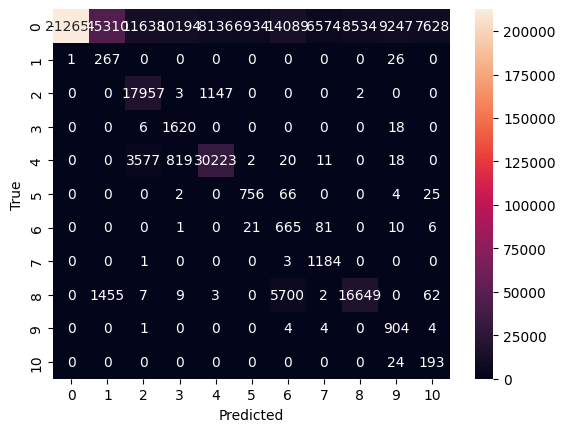

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(true_labels, predicted_labels):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Visualize the confusion matrix
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# After your evaluate_model function
accuracy, balanced_accuracy, f1, precision, recall, macro_f1, macro_precision, macro_recall,true_labels, predicted_labels = evaluate_model(model, test_loader)

# Print confusion matrix
print_confusion_matrix(true_labels, predicted_labels)

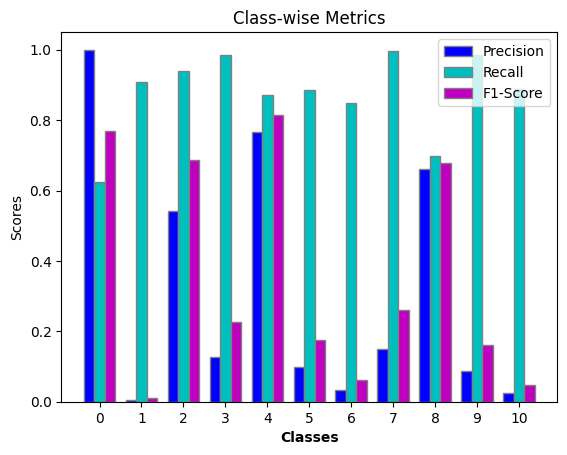

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have your classification report in a dictionary
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Collecting class labels, precision, recall, and f1-score
labels = []
precision = []
recall = []
f1_score = []

for label, metrics in report.items():
    if label.isdigit():
        labels.append(label)
        precision.append(metrics['precision'])
        recall.append(metrics['recall'])
        f1_score.append(metrics['f1-score'])

# Setting bar width and index for the X-axis
barWidth = 0.25
r1 = np.arange(len(labels))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Plotting the bar chart
plt.bar(r1, precision, color='b', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='c', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='m', width=barWidth, edgecolor='grey', label='F1-Score')

# Adding labels and title
plt.xlabel('Classes', fontweight='bold')
plt.ylabel('Scores')
plt.title('Class-wise Metrics')
plt.xticks([r + barWidth for r in range(len(labels))], labels)

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Print class distribution before balancing
unique_before, counts_before = np.unique(y, return_counts=True)
print("Class distribution before balancing:", dict(zip(unique_before, counts_before)))

Class distribution before balancing: {0: 2273097, 1: 1966, 2: 128027, 3: 10293, 4: 231073, 5: 5499, 6: 5796, 7: 7938, 8: 158930, 9: 5897, 10: 1507}


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have 'true_labels' and 'predicted_labels'
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Now 'report' is a dictionary containing all the metrics
for label, metrics in report.items():
    if label.isdigit():  # Check if the key is a class label
        print(f"Class {label}:")
        print(f"  Precision: {metrics['precision']}")
        print(f"  Recall: {metrics['recall']}")
        print(f"  F1 Score: {metrics['f1-score']}")
        print(f"  Support: {metrics['support']}")



Class 0:
  Precision: 0.9999801149356718
  Recall: 0.7377198284208735
  F1 Score: 0.8490593115744437
  Support: 340834
Class 1:
  Precision: 0.012005795901469675
  Recall: 0.9385113268608414
  F1 Score: 0.023708306082406802
  Support: 309
Class 2:
  Precision: 0.5194501718213058
  Recall: 0.981303557517528
  F1 Score: 0.6793097249685421
  Support: 19255
Class 3:
  Precision: 0.20920162381596752
  Recall: 0.9822109275730623
  F1 Score: 0.3449352967425257
  Support: 1574
Class 4:
  Precision: 0.8007176000863279
  Recall: 0.852632788486398
  F1 Score: 0.8258601260451592
  Support: 34811
Class 5:
  Precision: 0.25784087157477714
  Recall: 0.9571078431372549
  F1 Score: 0.4062418725617685
  Support: 816
Class 6:
  Precision: 0.09941520467836257
  Recall: 0.6453143534994069
  F1 Score: 0.17228820269200315
  Support: 843
Class 7:
  Precision: 0.1457838850718301
  Recall: 0.9991438356164384
  F1 Score: 0.2544423852610923
  Support: 1168
Class 8:
  Precision: 0.7321325740610404
  Recall: 0.9623